In [6]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [7]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [8]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

Running ring
GENERATION 0 START
Generation 0: Best fitness = 321.8681287703661 Average Fitness = 191.94375919576106
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 326.6228436308076 Average Fitness = 215.86241538462144
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 449.2207352964912 Average Fitness = 234.61290169543568
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 449.2207352964912 Average Fitness = 243.16973759518652
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 519.7190463762445 Average Fitness = 258.57297611363015
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 542.2588035326528 Average Fitness = 275.9799443071274
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 600.0668346131309 Average Fitness = 295.4027966579122
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 600.0668346131309 Average Fitness = 322.87030914821645
GENERATION 7 END
GENERATION 8 START
Generation

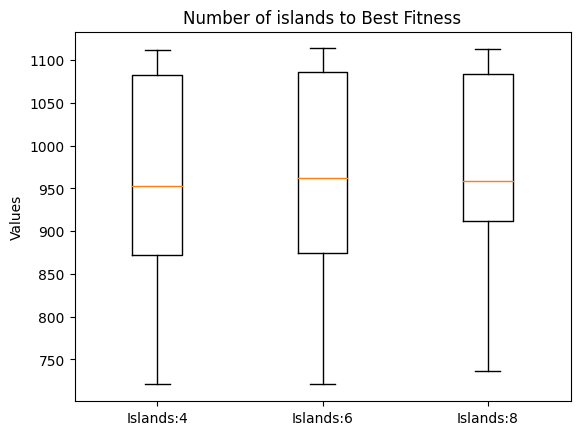

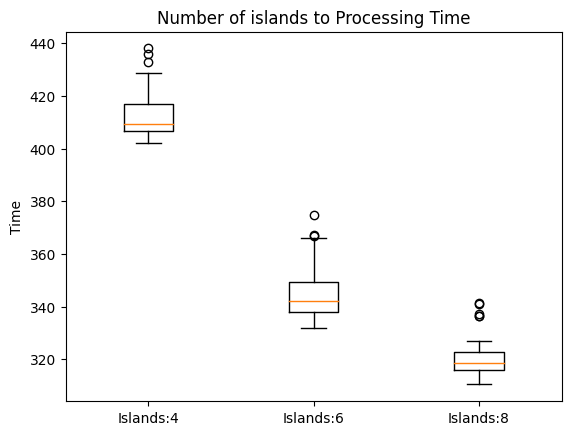

In [8]:
# ring
import matplotlib.pyplot as plt

fitness_values = {4:[],6:[],8:[]}
speed_values =  {4:[],6:[],8:[]}
number_of_islands =[ 4, 6, 8,]

for i in number_of_islands:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=train_data,num_islands=i,m_iter=25,num_iter=50,n_migrants=30,pSize=200,r_cross=0.6,r_mut=0.1,strategies=strategies,evolve_strategy="ring")
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        fitness_values[i].append(ga.globalBest.fitness_value)


# Generate some random data for three groups
#data1 = np.random.normal(0, 1, size=100)
#data2 = np.random.normal(2, 1, size=100)
#data3 = np.random.normal(5, 1, size=100)

# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  number_of_islands]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Islands:4', 'Islands:6','Islands:8'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Number of islands to Best Fitness')

# Show the plot
plt.show()

#### time plot
# Combine the fitness data into a list
speed_data = [speed_values[i] for i in  number_of_islands]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Islands:4', 'Islands:6','Islands:8'])

# Set the y-axis label
ax.set_ylabel('Time')

# Set the title of the plot
ax.set_title('Number of islands to Processing Time')

# Show the plot
plt.show()


Running master_slave
Generation 0: Best fitness = 340.7595642239434 Average fitness = 199.14017838526811
Generation 1: Best fitness = 354.9104483297505 Average fitness = 220.9648008841946
Generation 2: Best fitness = 393.66801687724995 Average fitness = 239.63893786491343
Generation 3: Best fitness = 562.4070195613626 Average fitness = 262.3950210646516
Generation 4: Best fitness = 602.0590574085305 Average fitness = 293.3146802190389
Generation 5: Best fitness = 602.0590574085305 Average fitness = 329.36459293950907
Generation 6: Best fitness = 602.0590574085305 Average fitness = 361.049723408392
Generation 7: Best fitness = 686.6438605107318 Average fitness = 404.6911405811072
Generation 8: Best fitness = 779.983812789998 Average fitness = 464.5865867470518
Generation 9: Best fitness = 779.983812789998 Average fitness = 515.1549425007248
Generation 10: Best fitness = 779.983812789998 Average fitness = 539.0423995096382
Generation 11: Best fitness = 779.983812789998 Average fitness = 

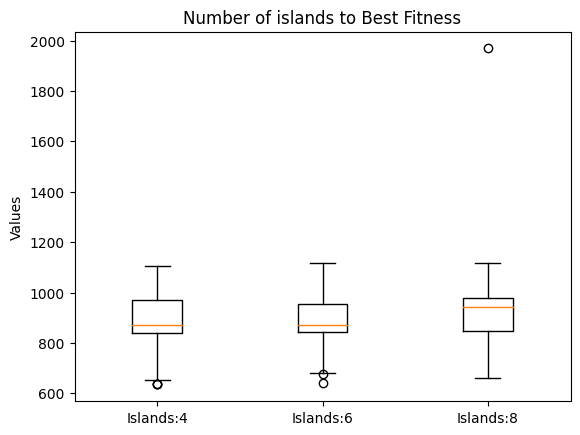

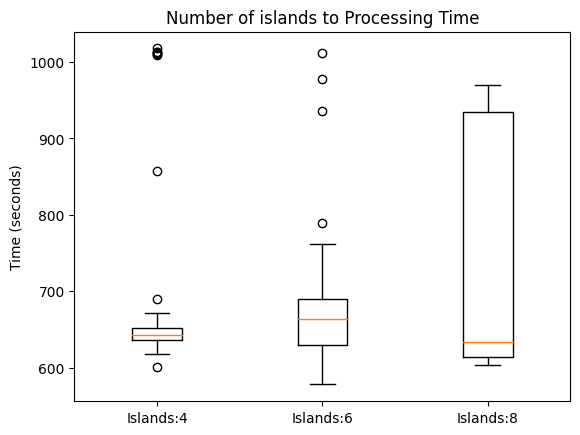

In [9]:
# master_slave
import matplotlib.pyplot as plt

fitness_values = {4:[],6:[],8:[]}
speed_values =  {4:[],6:[],8:[]}
number_of_islands =[ 4, 6, 8,]

for i in number_of_islands:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=train_data,num_islands=i,m_iter=25,num_iter=50,n_migrants=30,pSize=200,r_cross=0.6,r_mut=0.1,strategies=strategies,evolve_strategy="master_slave")
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        fitness_values[i].append(ga.globalBest.fitness_value)


# Generate some random data for three groups
#data1 = np.random.normal(0, 1, size=100)
#data2 = np.random.normal(2, 1, size=100)
#data3 = np.random.normal(5, 1, size=100)

# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  number_of_islands]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Islands:4', 'Islands:6','Islands:8'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Number of islands to Best Fitness')

# Show the plot
plt.show()

#### time plot
# Combine the fitness data into a list
speed_data = [speed_values[i] for i in  number_of_islands]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Islands:4', 'Islands:6','Islands:8'])

# Set the y-axis label
ax.set_ylabel('Time (seconds)')

# Set the title of the plot                                             `1      `
ax.set_title('Number of islands to Processing Time')

# Show the plot
plt.show()
